# **An exploration of the predictive abilities of Random Forest Regression via LEGO Sets**

The main goal of this project is mastery and understanding of Random Forest Regression via testing its abilities of prediction. To do this, I used a public dataset of LEGO sets and pieces that can be found [**here**](https://www.kaggle.com/datasets/rtatman/lego-database?select=colors.csv). I aim to answer the following question: *Using the set name, the theme of the set, the unique parts of the set, and the colors of the set, can a model predict how many total pieces are in a set?*

In other words, using select features of a LEGO set, can a model predict the total number of pieces (or bricks) in a set? I chose this question as it was included in part of the set, giving the model sufficient training data. I also chose this question as it would be able to answer questions about trends and patterns within LEGO sets. For example, do LEGO sets of similar themes have similar numbers of pieces in them? 

A Random Forest Regression was the model of choice as it is very good at fighting against outliers and avoiding overfitting. These are especially prominent in a set like this as LEGO sets have a large variety of piece totals, ranging from as simple as four pieces to as complex as thousands of pieces. The model will be able to fight agaisnt this variety to better observe the overall trends. 

The very first step, as detailed below, is to load the data in. The data began as six different CSVs which I load below. I added in statsmodels and sklearn libraries as a safeguard, as I did not know what I would end up needing and wanted to have as many tools available to me as possible. 

In [3]:
## Loading the data
import pandas as pd
import numpy as np
colorsDf = pd.read_csv("/home/anc110/Sum25FinalProject/colors.csv")
partsDf = pd.read_csv("/home/anc110/Sum25FinalProject/parts.csv")
setsDf = pd.read_csv("/home/anc110/Sum25FinalProject/sets.csv")
themesDf = pd.read_csv("/home/anc110/Sum25FinalProject/themes.csv")
inventoriesDf = pd.read_csv('inventories.csv')
inventory_parts_df = pd.read_csv("inventory_parts.csv")
# Link to source of dataset with code book: https://www.kaggle.com/datasets/rtatman/lego-database?resource=download&select=colors.csv

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Libraries and Modules
# Running regressions:
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit Learn
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier

## **Step 1.1**

First, I begin by doing some data cleaning. I take columns with the same names and renaming to make them unique (e.g. "id" to "color_id"). This is to clairfy the columns and make it easier to merge them based on same columns later on. 

In [4]:
colorsDf = colorsDf.rename(columns={"id": "color_id", "name": "color_name"})
colorsDf

partsDf  = partsDf.rename(columns={"name": "part_name"})
partsDf

setsDf = setsDf.rename(columns={"name": "set_name"})
setsDf

,set_num,set_name,year,theme_id,num_parts
0,00-1,Weetabix Castle,1970,414,471
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
3,0012-1,Space Mini-Figures,1979,143,12
4,0013-1,Space Mini-Figures,1979,143,12
...,...,...,...,...,...
11668,Wauwatosa-1,"LEGO Store Grand Opening Exclusive Set, Mayfai...",2012,408,15
11669,WHITEHOUSE-1,Micro White House,2015,598,59
11670,Wiesbaden-1,"LEGO Store Grand Opening Exclusive Set, Wiesba...",2010,408,146
11671,WishingWell-1,Wishing Well [Toys R Us Promo],2013,494,28


## **Step 1.2**

Next in cleaning, I begin to merge the dataframes with the same columns. I do this in increments so that it is easier to track what is being merged with what. I begin with merging *themes.csv* with *set.csv*. Next are the inventory CSVs, which I combine into one bigger *total_inventory* dataframe. 

In [5]:
themesDf = themesDf.rename(columns={"id": "theme_id", "name": "theme_name"})
# themesDf = themesDf.drop("parent_id", axis=1)
themesDf

theme_and_set = pd.merge(setsDf, themesDf, on="theme_id")
theme_and_set = theme_and_set.rename(columns={"name":"set_name"})
theme_and_set

,set_num,set_name,year,theme_id,num_parts,theme_name,parent_id
0,00-1,Weetabix Castle,1970,414,471,Castle,411.0
1,0011-2,Town Mini-Figures,1978,84,12,Supplemental,67.0
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,Lion Knights,186.0
3,0012-1,Space Mini-Figures,1979,143,12,Supplemental,126.0
4,0013-1,Space Mini-Figures,1979,143,12,Supplemental,126.0
...,...,...,...,...,...,...,...
11668,Wauwatosa-1,"LEGO Store Grand Opening Exclusive Set, Mayfai...",2012,408,15,LEGO Brand Store,NaN
11669,WHITEHOUSE-1,Micro White House,2015,598,59,Promotional,NaN
11670,Wiesbaden-1,"LEGO Store Grand Opening Exclusive Set, Wiesba...",2010,408,146,LEGO Brand Store,NaN
11671,WishingWell-1,Wishing Well [Toys R Us Promo],2013,494,28,Friends,NaN


In [6]:
inventoriesDf = inventoriesDf.rename(columns={"id": "inventory_id"})

total_inventory_df = pd.merge(inventoriesDf, inventory_parts_df, on='inventory_id')
total_inventory_df

,inventory_id,version,set_num,part_num,color_id,quantity,is_spare
0,1,1,7922-1,48379c01,72,1,f
1,1,1,7922-1,48395,7,1,f
2,1,1,7922-1,mcsport6,25,1,f
3,1,1,7922-1,paddle,0,1,f
4,3,1,3931-1,11816pr0005,78,1,f
...,...,...,...,...,...,...,...
580246,18708,1,75090-2,99206,0,3,f
580247,18708,1,75090-2,99207,71,4,f
580248,18708,1,75090-2,99780,15,4,f
580249,18708,1,75090-2,99780,0,9,f


## **Step 1.3**

The final step in my data cleaning process is to combine every CSV into one singular data frame. I begin with an empty data frame for a clean slate. Then, I begin merging the established data frames based on the same principle I did before, finding columns of the same name and doing an "inner" merge on that column. I do it one data frame at a time as to ensure easy tracing. 

Finally, I drop all the columns that will not hold immediate relevance to my research question. This included taking out the categorical versions of the variables I did intend to use. For example, I kept the column *color_id* but dropped the column *color_name*. I chose to use the numerical counterparts due to the amount of unique categorical values, such as the *part_num* column which holds over ten thousand unique values. Creating the necessary dummies for these variables would create an obscenely large data frame that would use an unneccesary amount of computing power. Hence, I dropped them in favor of their numerical counterparts. 

To complete the cleaning, I dropped all NA values. My completed data frame is held in *lego_df*.

In [12]:
lego_df = pd.DataFrame()

lego_df = pd.merge(total_inventory_df, partsDf, on = "part_num")
lego_df = pd.merge(lego_df, colorsDf, on = "color_id")
lego_df = pd.merge(lego_df, theme_and_set, on = "set_num")
lego_df = lego_df.rename(columns={"name":"part_name"})
lego_df = lego_df.drop(["version","year","is_spare", "rgb", "is_trans", "quantity", "color_name", "part_name"], axis=1)
lego_df = lego_df.dropna()
lego_df["log_num_parts"] = np.log(lego_df["num_parts"])
# lego_df.to_csv("lego.csv", index = True)
lego_df.head()

# lego_col_names

,inventory_id,set_num,part_num,color_id,part_cat_id,set_name,theme_id,num_parts,theme_name,parent_id,log_num_parts
0,1,7922-1,48379c01,72,27,McDonald's Sports Set Number 6 - Orange Vest S...,460,4,Gravity Games,458.0,1.386294
1,1,7922-1,48395,7,27,McDonald's Sports Set Number 6 - Orange Vest S...,460,4,Gravity Games,458.0,1.386294
2,1,7922-1,mcsport6,25,13,McDonald's Sports Set Number 6 - Orange Vest S...,460,4,Gravity Games,458.0,1.386294
3,1,7922-1,paddle,0,27,McDonald's Sports Set Number 6 - Orange Vest S...,460,4,Gravity Games,458.0,1.386294
33,4,6942-1,30214,34,27,Zo Weevil,134,20,Insectoids,126.0,2.995732


## **Step 2.1**

After the data cleaning, now is the time to choose my target and features for the model to train off of. I decided to use the following variables as features:

* ***part_cat_id***: An identifier of what kind of part the LEGO brick associated is. Categories include such things as "4x4 brick", "Mini fig head", etc. encoded as numbers.

* ***color_id***: An identifier of the color of the LEGO brick.

* ***inventory_id***: An identifier of what set the LEGO brick is a part of. A LEGO brick of any category can be a part of multiple sets at once. 

* ***theme_id***: An identifier of what theme the associated LEGO set is a part of. A theme is the overarching series the set belongs to, such as "Friends" or "Duplo". 

I choose these features for the following reasons:

* ***part_cat_id***: Knowing the kind of LEGO brick will allow the machine to identify patterns associated with the break. An example can be knowing that a brick is under the "wheel" category and inferring that there will be at least 4 of those based on previous knowledge of LEGO sets with "wheel" category parts.

* ***color_id***: While color may seem insignificant, certain LEGO sets are color-based and use coloring as an identifier on its own.

* ***inventory_id***: On first glance, it may seem as if this would give away the number of parts. But, I choose it becuase studying the trends among similar sets can possibly help to identify a minimum number of parts included. 

* ***theme_id***: I predict that this variable will hold the most weight in identifying trends as similar themes should have similar LEGO parts and totals.

Finally, I chose *num_parts* as my target variable as it is what I am trying to predict, the total number of parts in any given set. I logged it to reduce noise in the set.

In [8]:
target = "log_num_parts"
predictors = ['part_cat_id', 
              'color_id', 
              'inventory_id',  
              'theme_id']

## **Step 2.2**

Here, I begin by creating a new dataframe of the select target and predictors I chose. I do this to avoid using superfluous data that can distract the model. The model is only given relevant data. I ensure that any NAs are dropped as well. 

Next, I prepare the model for training by setting up the **X** matrix of predictors and **y** vector of the target. Using these new variables, I set up four more variables explicitly to be used in training and testing: *X_train*, *X_test*, *y_train*, and *y_test*. Using the function *train_test_split*, I split up the *lego_ml* data frame into training and testing sections based on the previous variables. Through experimenting with the model, I found the model to work most accurately when given 80% of the data to train on and using the other 20% as a test. I chose the random state of 13 as it is my lucky number and I wanted to ensure replicable results. 

In [13]:
# Preparing model variables and training
lego_ml_dat = lego_df[[target] + predictors]
lego_ml_dat.dropna()
lego_ml_dat.head()
y = lego_ml_dat[target]
X = lego_ml_dat[predictors]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, 
    random_state = 13
)


## **Step 2.3**

Now, it is time to run, train, and test the model. Through multiple experiments, I came to the conclusion that the model worked most accurately with 100 trees and default settings otherwise. I did tune the hyperparameters, such as *max_depth*, to see if messing with this could produce more accurate results. I also tuned the estimators amout, testing out up to 200 trees and as low as 80 trees. I noticed that after a certain number (in this case 100), the accuracy did not raise but rather stayed the same or lessened. So, for my final test I stuck with 100 estimators.

After creating the model with tuned hyperparameters, I fitted it using the training data I set up one step earlier. I created a *y_pred* vector to hold the predictions the model created based on the test data it was provided with. Finally, to see just how accurate the model was, I printed out the Mean Squared Error (MSE) and the Root MSE (RMSE).

The RMSE indicates the model predicts any given set within a 20(+/-) brick range. This indicates the model is doing better with larger sets than smaller sets.

In [14]:
# Random Forest Model
rf = RandomForestRegressor(n_estimators = 100, random_state = 13)  
rf.fit(X_train, y_train) 
y_pred = rf.predict(X_test)
print('Test set MSE of Random Forest: {:.2f}'.format(np.mean((y_test - y_pred)**2)))
RMSE = np.sqrt(np.mean((y_test - y_pred)**2))
print('Test set RMSE of Random Forest: {:.2f}'.format(RMSE))

Test set MSE of Random Forest: 437.18
Test set RMSE of Random Forest: 20.91


## **Step 3.1**

To help better understand how my model worked, I created a importances chart that shows the weighted importance of each feature on a scale of 0 to 1, with 1 meaning it was entirely dependent on this feature to predict values and 0 meaning it had little to no dependence on the feature. Suprisingly, the msot important feature was the set identification. In hindsight, this makes sense as sets of the same series are bound to have similar totals, or patterns of totals, to each other. Following this, as I predicted, knowing the theme of the set was heavily important for overall prediction. Most likely for the reasons I thought about earlier. 

What was really surprising was seeing that the knowledge of the category of part (wheel vs. 4x4 brick vs. minifig head for example) almost didn't matter at all. I think this is suprising because I hypothesized this would be more important under the idea that knowing a part category would allude to the typical number of that part in a given trend of sets. I believe it's unimportance may be due to the model predicting the *total number* of pieces rather than the *total breakdown of pieces* in a given set. 

Unsuprisingly, the color of the individual LEGO bricks had little to no relevance in prediction. Further testing would be needed to see if the mdoel worked to the same accuracy without the feature at all.

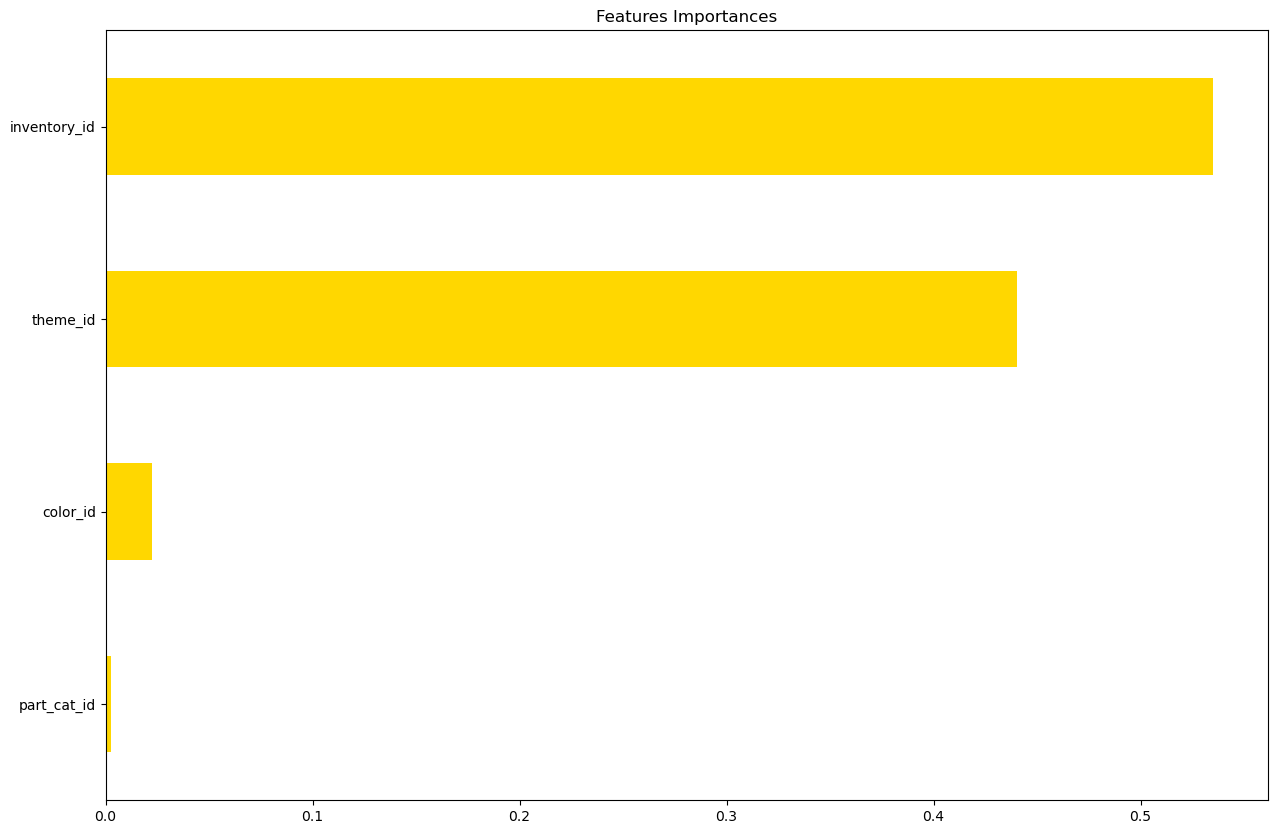

In [15]:
# Creating a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
fig = plt.figure(figsize = (15,10))
importances_sorted.tail(10).plot(kind='barh', color='gold')
plt.title('Features Importances')
plt.show()

## **Step 3.2**

The final step in my process was to visualize the accuracy of the model. I did this by charting a scatterplot that compared the actual number of parts in a set to the predicted number of parts. Every dot represents a given set, with the X coordinate being the actual value and the Y coordinate being the predicted value. As seen, the model is fairly accurate, especially as it comes to larger and larger sets. Where the model seems to fail is the smaller sets (such as those comprised of a single minifig or sets under the DUPLO theme), where it had a variety of differing predictions. 

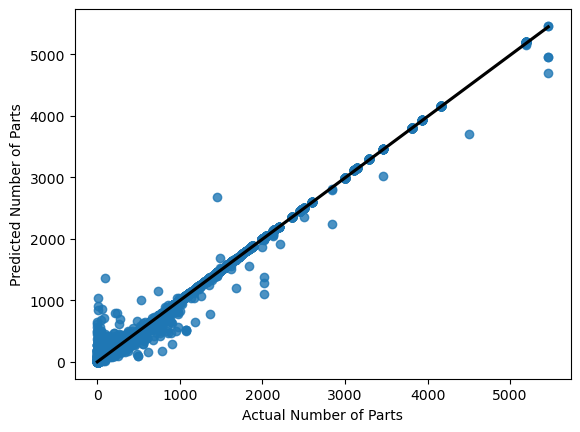

In [16]:
# Visualizations of predictions vs. actual values
scatter_df = pd.DataFrame()
scatter_df['Actual Number of Parts'] = y_test
scatter_df['Predicted Number of Parts'] = y_pred

sns.regplot(scatter_df, x = 'Actual Number of Parts', y = 'Predicted Number of Parts', line_kws=dict(color="black"))
plt.show()

## **Final Analysis**

Overall, I believe this project accomplished my original goal of understanding the predicitve abilities of Random Forest Regression and testing it out using a simple dataset. As stated earlier, the model is fairly accurate except for smaller sets. In closer analysis of the data frame used for the scatterplot, it appears as though the model was freat at predictions of sets with total part counts above three digits (100+ parts). It really becomes spot-on accurate when predicting sets that were larger than one thousand parts. 

I believe that this accuracy pitfall happened due to the variability of the data set. The data set used was very noisy, but this was a purposeful choice as to push the model to its limits in predictive power. It is interesting that it can't predict a small set well, over-predicting by nearly 20 parts on this end of the spectrum. If the data had been more normally distributed, I believe the model in its current forms and using its current parameters could become near entirerely accurate. 

There are some interesting conclusions about LEGO sets in here as well. Sets of similar names have very similar patterns of total parts, insinuating that even the naming conventions of LEGO sets follow certain conditions and rules. The same goes for set themes, these themes seem to be set up in such a way that similar themes will have entirely similar numbers of parts. This makes sense especially in terms of sets for younger children, for certain genders, for older adults, etc. All in all, my initial predictions were not too far off and I am excited to create an even more robust prediction model in the future. 